<a href="https://colab.research.google.com/github/uumami/workshop_riskmathics/blob/main/ts_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Workshop
Based on https://github.com/Nixtla/nixtla/tree/main/utils/experiments/zillow-prophet.

In [ ]:
pip install pandas==1.3.5

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pd.__version__

'1.3.5'

## Dataset

ZHVI is "a smoothed, seasonally adjusted measure of typical home value and market changes for a given region and housing type. It reflects the typical value of homes in the 35th to 65th percentile range" and "represents the “typical” home value for a region".

In [ ]:
!wget https://raw.githubusercontent.com/Nixtla/nixtla/main/utils/experiments/zillow-prophet/data/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv

--2022-01-25 20:00:41--  https://raw.githubusercontent.com/Nixtla/nixtla/main/utils/experiments/zillow-prophet/data/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1826435 (1.7M) [text/plain]
Saving to: ‘Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv.1’

Metro_zhvi_uc_sfrco 100%[===================>]   1.74M  --.-KB/s    in 0.05s   

2022-01-25 20:00:41 (31.8 MB/s) - ‘Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv.1’ saved [1826435/1826435]



In [ ]:
!ls

Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv	 sample_data
Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv.1


In [ ]:
df = pd.read_csv('Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

In [ ]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,...,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30
0,102001,0,United States,Country,NaN,127569.0,127914.0,128277.0,129016.0,129762.0,130505.0,131263.0,132072.0,132897.0,133728.0,134566.0,135425.0,136226.0,136963.0,137712.0,138511.0,139335.0,140143.0,140958.0,141800.0,142634.0,143473.0,144241.0,144976.0,145645.0,146344.0,147081.0,147861.0,148693.0,149568.0,150516.0,151507.0,152487.0,153471.0,154399.0,...,233820.0,234855.0,235835.0,236814.0,237781.0,238758.0,239753.0,240775.0,241718.0,242529.0,243230.0,243877.0,244480.0,245033.0,245593.0,246228.0,246943.0,247680.0,248510.0,249497.0,250644.0,251933.0,253157.0,254006.0,254714.0,255816.0,257737.0,260253.0,263080.0,266113.0,269165.0,272132.0,275247.0,278593.0,282335.0,286913.0,292304.0,298069.0,303296.0,308220.0
1,394913,1,"New York, NY",Msa,NY,225438.0,226785.0,227997.0,230383.0,232604.0,234969.0,237454.0,240026.0,242606.0,245159.0,247613.0,249910.0,252122.0,254555.0,256934.0,259418.0,261773.0,264319.0,266796.0,269475.0,272188.0,275180.0,277937.0,280597.0,283283.0,285900.0,288448.0,290906.0,293506.0,296454.0,299629.0,303552.0,307660.0,311762.0,315400.0,...,470440.0,471151.0,471856.0,473039.0,474740.0,476592.0,478161.0,479178.0,480058.0,480959.0,481965.0,482654.0,482852.0,482820.0,482546.0,482079.0,481540.0,481244.0,481784.0,482818.0,484301.0,485725.0,487222.0,488035.0,488594.0,489815.0,492415.0,496938.0,502448.0,508501.0,514350.0,519193.0,523962.0,528241.0,532983.0,538439.0,545638.0,553551.0,561136.0,567059.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,231209.0,232014.0,233247.0,235592.0,238105.0,240479.0,242910.0,245461.0,247891.0,250113.0,252170.0,254337.0,256001.0,257805.0,259727.0,262406.0,265034.0,267457.0,269935.0,272519.0,275198.0,277854.0,280168.0,282603.0,284611.0,286977.0,289795.0,293379.0,297456.0,301615.0,306850.0,312302.0,317852.0,322809.0,327730.0,...,660565.0,660997.0,661875.0,662325.0,665582.0,667436.0,666925.0,665764.0,663614.0,662272.0,661841.0,662809.0,663827.0,662891.0,663616.0,666330.0,670631.0,672643.0,674454.0,677430.0,683527.0,690489.0,695613.0,693703.0,690803.0,692544.0,701716.0,712332.0,722297.0,729787.0,736123.0,741232.0,748830.0,756443.0,767598.0,783132.0,803315.0,824025.0,837548.0,846526.0
3,394463,3,"Chicago, IL",Msa,IL,170602.0,171004.0,171525.0,172568.0,173673.0,174768.0,175979.0,177338.0,178743.0,180125.0,181380.0,182607.0,183756.0,184773.0,185926.0,187060.0,188457.0,189749.0,191055.0,192376.0,193710.0,195136.0,196320.0,197391.0,198304.0,199368.0,200651.0,201729.0,202936.0,204042.0,205524.0,207038.0,208502.0,209848.0,210811.0,...,236897.0,237309.0,237609.0,238258.0,238762.0,239539.0,240159.0,240695.0,241438.0,241904.0,242413.0,242472.0,242399.0,242359.0,242290.0,242286.0,242178.0,242186.0,242399.0,242882.0,243491.0,244022.0,244150.0,243982.0,243952.0,244966.0,246635.0,249528.0,252392.0,255201.0,257432.0,258905.0,261216.0,263319.0,266367.0,269105.0,272894.0,277086.0,281183.0,284285.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,130189.0,130293.0,130379.0,130591.0,130813.0,130998.0,131197.0,131563.0,132018.0,132548.0,133032.0,133525.0,133737.0,133416.0,133135.0,133016.0,133234.0,133301.0,133373.0,133667.0,133894.0,134097.0,134146.

In [ ]:
df.shape

(909, 266)

In [ ]:
for col in ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']:
  print(f'Numero de valores unicos {col}: {df[col].nunique()}')
  print(f'Valores faltantes {col}: {df[col].isna().sum()}\n')

Numero de valores unicos RegionID: 909
Valores faltantes RegionID: 0

Numero de valores unicos SizeRank: 905
Valores faltantes SizeRank: 0

Numero de valores unicos RegionName: 909
Valores faltantes RegionName: 0

Numero de valores unicos RegionType: 2
Valores faltantes RegionType: 0

Numero de valores unicos StateName: 51
Valores faltantes StateName: 1



In [ ]:
renamer = {'RegionID': 'unique_id'}

In [ ]:
df.rename(columns=renamer, inplace=True)

In [ ]:
df.head()

,unique_id,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,...,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30
0,102001,0,United States,Country,NaN,127569.0,127914.0,128277.0,129016.0,129762.0,130505.0,131263.0,132072.0,132897.0,133728.0,134566.0,135425.0,136226.0,136963.0,137712.0,138511.0,139335.0,140143.0,140958.0,141800.0,142634.0,143473.0,144241.0,144976.0,145645.0,146344.0,147081.0,147861.0,148693.0,149568.0,150516.0,151507.0,152487.0,153471.0,154399.0,...,233820.0,234855.0,235835.0,236814.0,237781.0,238758.0,239753.0,240775.0,241718.0,242529.0,243230.0,243877.0,244480.0,245033.0,245593.0,246228.0,246943.0,247680.0,248510.0,249497.0,250644.0,251933.0,253157.0,254006.0,254714.0,255816.0,257737.0,260253.0,263080.0,266113.0,269165.0,272132.0,275247.0,278593.0,282335.0,286913.0,292304.0,298069.0,303296.0,308220.0
1,394913,1,"New York, NY",Msa,NY,225438.0,226785.0,227997.0,230383.0,232604.0,234969.0,237454.0,240026.0,242606.0,245159.0,247613.0,249910.0,252122.0,254555.0,256934.0,259418.0,261773.0,264319.0,266796.0,269475.0,272188.0,275180.0,277937.0,280597.0,283283.0,285900.0,288448.0,290906.0,293506.0,296454.0,299629.0,303552.0,307660.0,311762.0,315400.0,...,470440.0,471151.0,471856.0,473039.0,474740.0,476592.0,478161.0,479178.0,480058.0,480959.0,481965.0,482654.0,482852.0,482820.0,482546.0,482079.0,481540.0,481244.0,481784.0,482818.0,484301.0,485725.0,487222.0,488035.0,488594.0,489815.0,492415.0,496938.0,502448.0,508501.0,514350.0,519193.0,523962.0,528241.0,532983.0,538439.0,545638.0,553551.0,561136.0,567059.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,231209.0,232014.0,233247.0,235592.0,238105.0,240479.0,242910.0,245461.0,247891.0,250113.0,252170.0,254337.0,256001.0,257805.0,259727.0,262406.0,265034.0,267457.0,269935.0,272519.0,275198.0,277854.0,280168.0,282603.0,284611.0,286977.0,289795.0,293379.0,297456.0,301615.0,306850.0,312302.0,317852.0,322809.0,327730.0,...,660565.0,660997.0,661875.0,662325.0,665582.0,667436.0,666925.0,665764.0,663614.0,662272.0,661841.0,662809.0,663827.0,662891.0,663616.0,666330.0,670631.0,672643.0,674454.0,677430.0,683527.0,690489.0,695613.0,693703.0,690803.0,692544.0,701716.0,712332.0,722297.0,729787.0,736123.0,741232.0,748830.0,756443.0,767598.0,783132.0,803315.0,824025.0,837548.0,846526.0
3,394463,3,"Chicago, IL",Msa,IL,170602.0,171004.0,171525.0,172568.0,173673.0,174768.0,175979.0,177338.0,178743.0,180125.0,181380.0,182607.0,183756.0,184773.0,185926.0,187060.0,188457.0,189749.0,191055.0,192376.0,193710.0,195136.0,196320.0,197391.0,198304.0,199368.0,200651.0,201729.0,202936.0,204042.0,205524.0,207038.0,208502.0,209848.0,210811.0,...,236897.0,237309.0,237609.0,238258.0,238762.0,239539.0,240159.0,240695.0,241438.0,241904.0,242413.0,242472.0,242399.0,242359.0,242290.0,242286.0,242178.0,242186.0,242399.0,242882.0,243491.0,244022.0,244150.0,243982.0,243952.0,244966.0,246635.0,249528.0,252392.0,255201.0,257432.0,258905.0,261216.0,263319.0,266367.0,269105.0,272894.0,277086.0,281183.0,284285.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,130189.0,130293.0,130379.0,130591.0,130813.0,130998.0,131197.0,131563.0,132018.0,132548.0,133032.0,133525.0,133737.0,133416.0,133135.0,133016.0,133234.0,133301.0,133373.0,133667.0,133894.0,134097.0,134146

In [ ]:
df.drop(columns=['SizeRank', 'RegionName', 'RegionType', 'StateName'], inplace=True)

In [ ]:
df.head()

,unique_id,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,...,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30
0,102001,127569.0,127914.0,128277.0,129016.0,129762.0,130505.0,131263.0,132072.0,132897.0,133728.0,134566.0,135425.0,136226.0,136963.0,137712.0,138511.0,139335.0,140143.0,140958.0,141800.0,142634.0,143473.0,144241.0,144976.0,145645.0,146344.0,147081.0,147861.0,148693.0,149568.0,150516.0,151507.0,152487.0,153471.0,154399.0,155325.0,156169.0,157030.0,157913.0,...,233820.0,234855.0,235835.0,236814.0,237781.0,238758.0,239753.0,240775.0,241718.0,242529.0,243230.0,243877.0,244480.0,245033.0,245593.0,246228.0,246943.0,247680.0,248510.0,249497.0,250644.0,251933.0,253157.0,254006.0,254714.0,255816.0,257737.0,260253.0,263080.0,266113.0,269165.0,272132.0,275247.0,278593.0,282335.0,286913.0,292304.0,298069.0,303296.0,308220.0
1,394913,225438.0,226785.0,227997.0,230383.0,232604.0,234969.0,237454.0,240026.0,242606.0,245159.0,247613.0,249910.0,252122.0,254555.0,256934.0,259418.0,261773.0,264319.0,266796.0,269475.0,272188.0,275180.0,277937.0,280597.0,283283.0,285900.0,288448.0,290906.0,293506.0,296454.0,299629.0,303552.0,307660.0,311762.0,315400.0,319080.0,322784.0,326589.0,330669.0,...,470440.0,471151.0,471856.0,473039.0,474740.0,476592.0,478161.0,479178.0,480058.0,480959.0,481965.0,482654.0,482852.0,482820.0,482546.0,482079.0,481540.0,481244.0,481784.0,482818.0,484301.0,485725.0,487222.0,488035.0,488594.0,489815.0,492415.0,496938.0,502448.0,508501.0,514350.0,519193.0,523962.0,528241.0,532983.0,538439.0,545638.0,553551.0,561136.0,567059.0
2,753899,231209.0,232014.0,233247.0,235592.0,238105.0,240479.0,242910.0,245461.0,247891.0,250113.0,252170.0,254337.0,256001.0,257805.0,259727.0,262406.0,265034.0,267457.0,269935.0,272519.0,275198.0,277854.0,280168.0,282603.0,284611.0,286977.0,289795.0,293379.0,297456.0,301615.0,306850.0,312302.0,317852.0,322809.0,327730.0,332593.0,336688.0,340469.0,344653.0,...,660565.0,660997.0,661875.0,662325.0,665582.0,667436.0,666925.0,665764.0,663614.0,662272.0,661841.0,662809.0,663827.0,662891.0,663616.0,666330.0,670631.0,672643.0,674454.0,677430.0,683527.0,690489.0,695613.0,693703.0,690803.0,692544.0,701716.0,712332.0,722297.0,729787.0,736123.0,741232.0,748830.0,756443.0,767598.0,783132.0,803315.0,824025.0,837548.0,846526.0
3,394463,170602.0,171004.0,171525.0,172568.0,173673.0,174768.0,175979.0,177338.0,178743.0,180125.0,181380.0,182607.0,183756.0,184773.0,185926.0,187060.0,188457.0,189749.0,191055.0,192376.0,193710.0,195136.0,196320.0,197391.0,198304.0,199368.0,200651.0,201729.0,202936.0,204042.0,205524.0,207038.0,208502.0,209848.0,210811.0,211975.0,213097.0,214459.0,215686.0,...,236897.0,237309.0,237609.0,238258.0,238762.0,239539.0,240159.0,240695.0,241438.0,241904.0,242413.0,242472.0,242399.0,242359.0,242290.0,242286.0,242178.0,242186.0,242399.0,242882.0,243491.0,244022.0,244150.0,243982.0,243952.0,244966.0,246635.0,249528.0,252392.0,255201.0,257432.0,258905.0,261216.0,263319.0,266367.0,269105.0,272894.0,277086.0,281183.0,284285.0
4,394514,130189.0,130293.0,130379.0,130591.0,130813.0,130998.0,131197.0,131563.0,132018.0,132548.0,133032.0,133525.0,133737.0,133416.0,133135.0,133016.0,133234.0,133301.0,133373.0,133667.0,133894.0,134097.0,134146.0,1342

In [ ]:
 df = df.set_index('unique_id')

In [ ]:
df.head()

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,...,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
102001,127569.0,127914.0,128277.0,129016.0,129762.0,130505.0,131263.0,132072.0,132897.0,133728.0,134566.0,135425.0,136226.0,136963.0,137712.0,138511.0,139335.0,140143.0,140958.0,141800.0,142634.0,143473.0,144241.0,144976.0,145645.0,146344.0,147081.0,147861.0,148693.0,149568.0,150516.0,151507.0,152487.0,153471.0,154399.0,155325.0,156169.0,157030.0,157913.0,158867.0,...,233820.0,234855.0,235835.0,236814.0,237781.0,238758.0,239753.0,240775.0,241718.0,242529.0,243230.0,243877.0,244480.0,245033.0,245593.0,246228.0,246943.0,247680.0,248510.0,249497.0,250644.0,251933.0,253157.0,254006.0,254714.0,255816.0,257737.0,260253.0,263080.0,266113.0,269165.0,272132.0,275247.0,278593.0,282335.0,286913.0,292304.0,298069.0,303296.0,308220.0
394913,225438.0,226785.0,227997.0,230383.0,232604.0,234969.0,237454.0,240026.0,242606.0,245159.0,247613.0,249910.0,252122.0,254555.0,256934.0,259418.0,261773.0,264319.0,266796.0,269475.0,272188.0,275180.0,277937.0,280597.0,283283.0,285900.0,288448.0,290906.0,293506.0,296454.0,299629.0,303552.0,307660.0,311762.0,315400.0,319080.0,322784.0,326589.0,330669.0,334467.0,...,470440.0,471151.0,471856.0,473039.0,474740.0,476592.0,478161.0,479178.0,480058.0,480959.0,481965.0,482654.0,482852.0,482820.0,482546.0,482079.0,481540.0,481244.0,481784.0,482818.0,484301.0,485725.0,487222.0,488035.0,488594.0,489815.0,492415.0,496938.0,502448.0,508501.0,514350.0,519193.0,523962.0,528241.0,532983.0,538439.0,545638.0,553551.0,561136.0,567059.0
753899,231209.0,232014.0,233247.0,235592.0,238105.0,240479.0,242910.0,245461.0,247891.0,250113.0,252170.0,254337.0,256001.0,257805.0,259727.0,262406.0,265034.0,267457.0,269935.0,272519.0,275198.0,277854.0,280168.0,282603.0,284611.0,286977.0,289795.0,293379.0,297456.0,301615.0,306850.0,312302.0,317852.0,322809.0,327730.0,332593.0,336688.0,340469.0,344653.0,349330.0,...,660565.0,660997.0,661875.0,662325.0,665582.0,667436.0,666925.0,665764.0,663614.0,662272.0,661841.0,662809.0,663827.0,662891.0,663616.0,666330.0,670631.0,672643.0,674454.0,677430.0,683527.0,690489.0,695613.0,693703.0,690803.0,692544.0,701716.0,712332.0,722297.0,729787.0,736123.0,741232.0,748830.0,756443.0,767598.0,783132.0,803315.0,824025.0,837548.0,846526.0
394463,170602.0,171004.0,171525.0,172568.0,173673.0,174768.0,175979.0,177338.0,178743.0,180125.0,181380.0,182607.0,183756.0,184773.0,185926.0,187060.0,188457.0,189749.0,191055.0,192376.0,193710.0,195136.0,196320.0,197391.0,198304.0,199368.0,200651.0,201729.0,202936.0,204042.0,205524.0,207038.0,208502.0,209848.0,210811.0,211975.0,213097.0,214459.0,215686.0,217089.0,...,236897.0,237309.0,237609.0,238258.0,238762.0,239539.0,240159.0,240695.0,241438.0,241904.0,242413.0,242472.0,242399.0,242359.0,242290.0,242286.0,242178.0,242186.0,242399.0,242882.0,243491.0,244022.0,244150.0,243982.0,243952.0,244966.0,246635.0,249528.0,252392.0,255201.0,257432.0,258905.0,261216.0,263319.0,266367.0,269105.0,272894.0,277086.0,281183.0,284285.0
394514,130189.0,130293.0,130379.0,130591.0,130813.0,130998.0,131197.0,131563.0,132018.0,132548.0,133

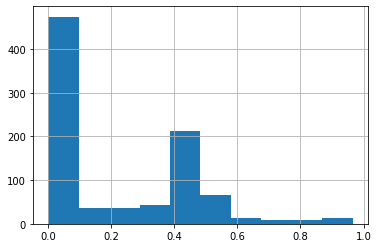

In [ ]:
df.isna().mean(axis=1).hist()

In [ ]:
df.isna().sum(axis=1).sort_values()

unique_id
102001      0
394788      0
394369      0
753915      0
394524      0
         ... 
394659    229
394968    239
394965    242
394656    252
753920    252
Length: 909, dtype: int64

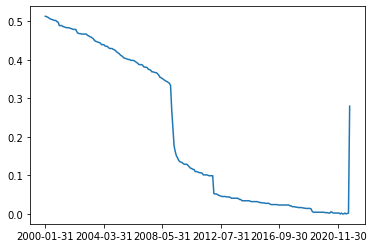

In [ ]:
df.isna().mean().plot()

### Wide to long format

In [ ]:
df = df.stack(dropna=False).rename_axis(['unique_id', 'ds']).rename('y').reset_index()

In [ ]:
df.head()

,unique_id,ds,y
0,102001,2000-01-31,127569.0
1,102001,2000-02-29,127914.0
2,102001,2000-03-31,128277.0
3,102001,2000-04-30,129016.0
4,102001,2000-05-31,129762.0


In [ ]:
df['y'] = df.groupby('unique_id')['y'].ffill()

In [ ]:
df.dropna(inplace=True)

In [ ]:
df['y'].isna().mean()

0.0

In [ ]:
def plot_grid(df_train, df_test=None):
  fig, axes = plt.subplots(2, 4, figsize = (24,8))

  unique_ids = df_train['unique_id'].unique()

  assert len(unique_ids) >= 8, "Must provide at least 8 ts"
  
  unique_ids = random.sample(set(unique_ids), k=8)

  for uid, (idx, idy) in zip(unique_ids, product(range(2), range(4))):
    train_uid = df_train.query('unique_id == @uid')

    axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'ts')
    if df_test is not None:
      test_uid = df_test.query('unique_id == @uid')
      for model in df_test.drop(['unique_id', 'ds'], axis=1).columns:
        axes[idx, idy].plot(test_uid['ds'], test_uid[model], label=model)
    
    axes[idx, idy].set_title(uid)
    axes[idx, idy].legend(loc='upper left')
    axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(4))

  plt.show()

2022-01-25 20:58:56 matplotlib.category INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-01-25 20:58:56 matplotlib.category INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-01-25 20:58:56 matplotlib.category INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-01-25 20:58:56 matplotlib.category INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-01-25 20:58:56 matplotlib.category INFO: Using cate

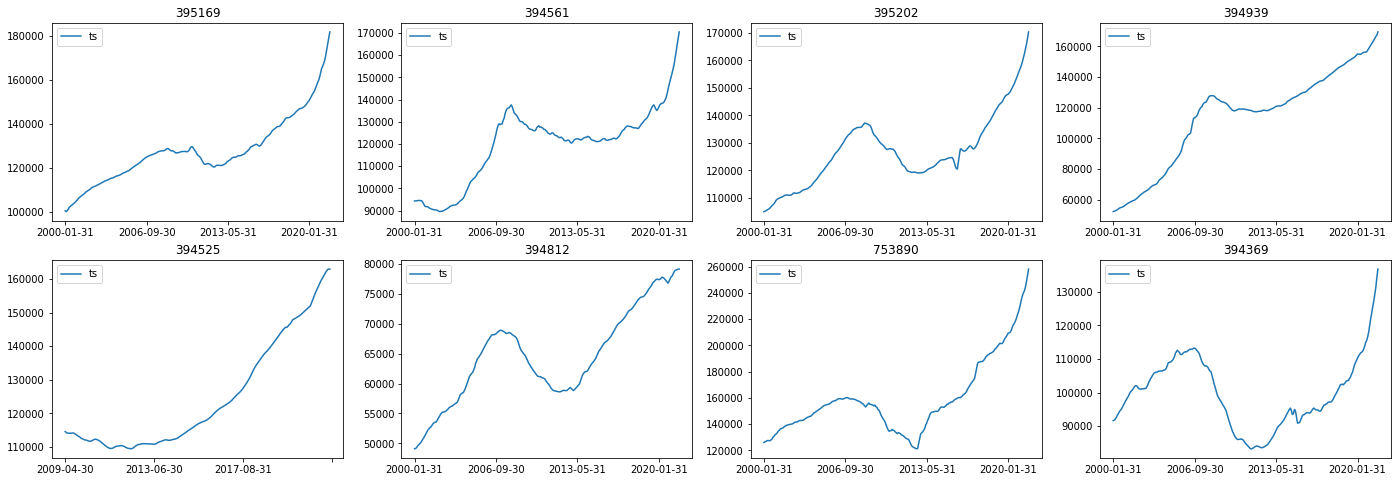

In [ ]:
plot_grid(df)

# Train + test partition

In [ ]:
test = df.groupby('unique_id').tail(4)
train = df.drop(test.index).copy()
test['ds'] = pd.to_datetime(test['ds'])
train['ds'] = pd.to_datetime(train['ds'])

In [ ]:
test.head()

,unique_id,ds,y
257,102001,2021-06-30,292304.0
258,102001,2021-07-31,298069.0
259,102001,2021-08-31,303296.0
260,102001,2021-09-30,308220.0
518,394913,2021-06-30,545638.0


In [ ]:
train.head()

,unique_id,ds,y
0,102001,2000-01-31,127569.0
1,102001,2000-02-29,127914.0
2,102001,2000-03-31,128277.0
3,102001,2000-04-30,129016.0
4,102001,2000-05-31,129762.0


In [ ]:
!pip install prophet sklearn nixtlats mlforecast statsforecast lightgbm

## Evaluation

In [ ]:
from itertools import product
import random

from nixtlats.losses.numpy import mape, rmse, smape, mae

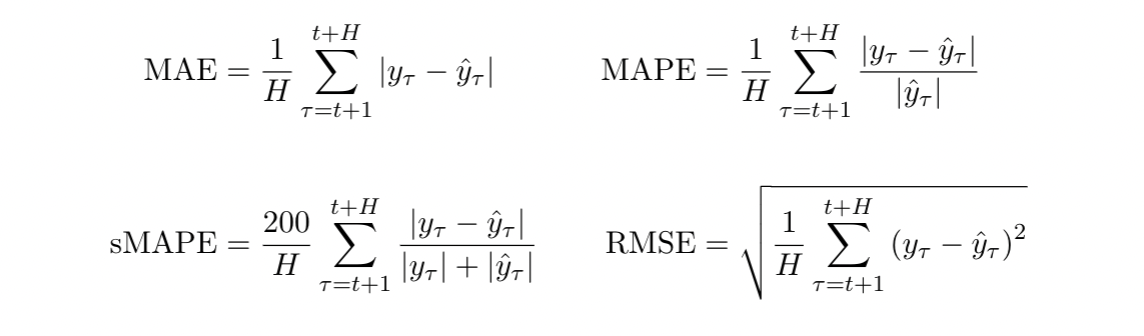

In [ ]:
def evaluate_dataset(df_eval, horizon):
  models = df_eval.drop(columns=['unique_id', 'ds', 'y']).columns.to_list()
  evals = {}
  y = df_eval['y'].values.reshape(-1, horizon)
  for model in models:
    evals[model] = {}
    y_hat = df_eval[model].values.reshape(-1, 4)
    for metric in (mape, rmse, smape, mae):
      evals[model][metric.__name__] = metric(y, y_hat, axis=1).mean()

  return pd.DataFrame(evals).T.sort_values('mape')

## Prophet

In [ ]:
from functools import partial
from multiprocessing import Pool, cpu_count

from prophet import Prophet
from sklearn.model_selection import ParameterGrid

In [ ]:
cpu_count()

2

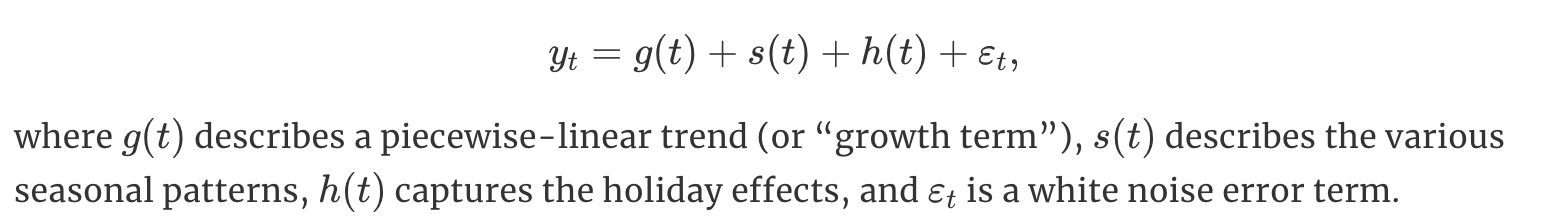

In [ ]:
params_grid = {'seasonality_mode': ['multiplicative','additive'],
               'changepoint_prior_scale': [0.1, 0.2],
               'fourier_order': [5, 9]}
grid = ParameterGrid(params_grid)

In [ ]:
def fit_and_predict(index, ts, horizon): 
    failed_hpo = False
    
    df = ts.drop('unique_id', 1)
    df_val = df.tail(horizon)
    df_train = df.drop(df_val.index)
    y_val = df_val['y'].values
    
    if len(df_train) >= horizon:
        val_results = {'losses': [], 'params': []}

        for params in grid:
            model = Prophet(seasonality_mode=params['seasonality_mode'],
                            weekly_seasonality=False,
                            changepoint_prior_scale=params['changepoint_prior_scale'])
            model.add_seasonality(name='monthly', 
                                  period=30.5, 
                                  fourier_order=params['fourier_order'])
            model = model.fit(df_train)
            
            forecast = model.make_future_dataframe(periods=horizon, 
                                                   include_history=False, 
                                                   freq='M')
            forecast = model.predict(forecast)
            forecast['unique_id'] = index
            forecast = forecast.filter(items=['unique_id', 'ds', 'yhat'])
            
            loss = mape(y_val, forecast['yhat'].values) 
            
            val_results['losses'].append(loss)
            val_results['params'].append(params)

        idx_params = np.argmin(val_results['losses']) 
        params = val_results['params'][idx_params]


    else:
        failed_hpo = True
        params = {'seasonality_mode': 'multiplicative',
                  'n_changepoints': 150,
                  'changepoint_prior_scale': 0.5,
                  'fourier_order': 5}
    
    model = Prophet(seasonality_mode=params['seasonality_mode'],
                    weekly_seasonality=False,
                    changepoint_prior_scale=params['changepoint_prior_scale'])
    model.add_seasonality(name='monthly', 
                          period=30.5, 
                          fourier_order=params['fourier_order'])
    model = model.fit(df)
    
    forecast = model.make_future_dataframe(periods=horizon, 
                                           include_history=False, 
                                           freq='M')
    forecast = model.predict(forecast)
    forecast['unique_id'] = index
    forecast = forecast.filter(items=['unique_id', 'ds', 'yhat'])

    return forecast, failed_hpo

In [ ]:
partial_fit_and_predict = partial(fit_and_predict, horizon=4)

In [ ]:
# will take forever with all ts
uid = df['unique_id'].unique()[:4]
train_dummy = train.query('unique_id in @uid')

In [ ]:
%%time
with Pool(cpu_count()) as pool:
  results_prophet = pool.starmap(partial_fit_and_predict, train_dummy.groupby('unique_id'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:p

CPU times: user 556 ms, sys: 108 ms, total: 665 ms
Wall time: 1min 30s


In [ ]:
forecasts_prophet_dummy, failed = zip(*results_prophet)
forecasts_prophet_dummy= pd.concat(forecasts_prophet_dummy)

In [ ]:
np.mean(failed)

0.0

In [ ]:
forecasts_prophet_dummy.head()

,unique_id,ds,yhat
0,102001,2021-06-30,283300.665030
1,102001,2021-07-31,282541.268536
2,102001,2021-08-31,274821.962461
3,102001,2021-09-30,284690.754630
0,394463,2021-06-30,267183.046484


In [ ]:
!wget https://raw.githubusercontent.com/Nixtla/nixtla/main/utils/experiments/zillow-prophet/data/prophet-forecasts.csv

--2022-01-25 20:38:39--  https://raw.githubusercontent.com/Nixtla/nixtla/main/utils/experiments/zillow-prophet/data/prophet-forecasts.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132822 (130K) [text/plain]
Saving to: ‘prophet-forecasts.csv’

prophet-forecasts.c 100%[===================>] 129.71K  --.-KB/s    in 0.02s   

2022-01-25 20:38:39 (6.24 MB/s) - ‘prophet-forecasts.csv’ saved [132822/132822]



In [ ]:
!ls

Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv	 prophet-forecasts.csv
Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv.1  sample_data


In [ ]:
forecasts_prophet = pd.read_csv('prophet-forecasts.csv')
forecasts_prophet['ds'] = pd.to_datetime(forecasts_prophet['ds'])

In [ ]:
forecasts_prophet.head()

,unique_id,ds,yhat
0,102001,2021-06-30,282831.471263
1,102001,2021-07-31,284001.324749
2,102001,2021-08-31,273896.163318
3,102001,2021-09-30,286137.934100
4,394297,2021-06-30,180762.065283


In [ ]:
forecasts_prophet.isna().mean()

unique_id    0.0
ds           0.0
yhat         0.0
dtype: float64

In [ ]:
forecasts_prophet.rename(columns={'yhat': 'prophet'}, inplace=True)

In [ ]:
test = test.merge(forecasts_prophet, how='left', on=['unique_id', 'ds'])

In [ ]:
evaluate_dataset(test, 4)

,mae,mape,rmse,smape
prophet,12429.364069,4.261593,13491.568388,4.424653


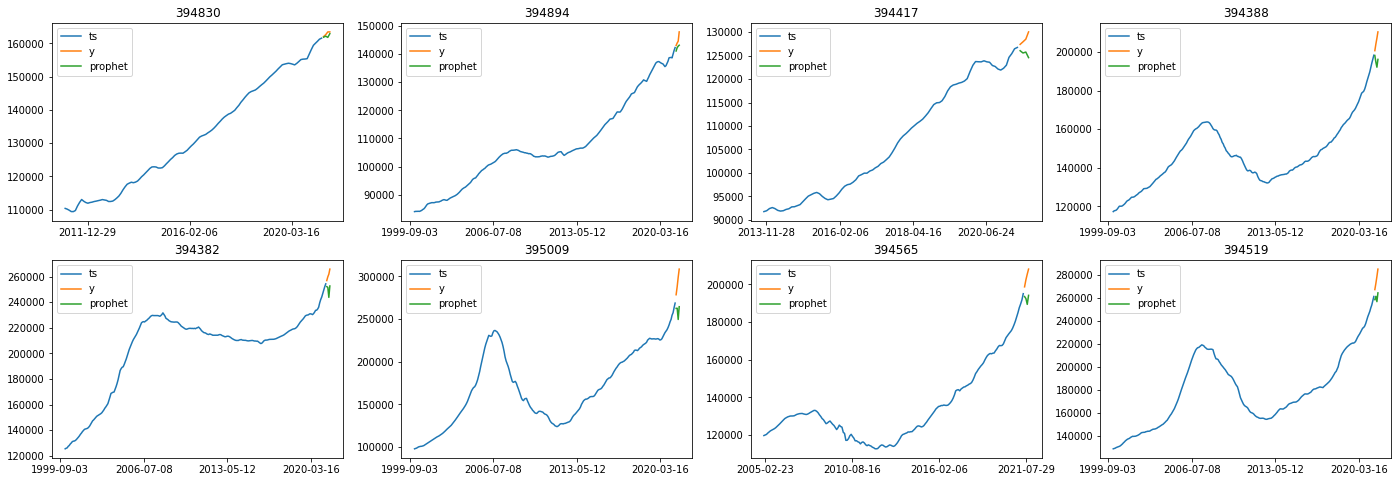

In [ ]:
plot_grid(train, test)

## Statsforecast

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import (
    historic_average,
    naive,
    random_walk_with_drift, 
    seasonal_naive, 
    ses, 
    window_average
)

In [ ]:
models = [
	historic_average,
	naive,
	random_walk_with_drift,
	(ses, 0.9),
  (window_average, 4)
]


### Naive
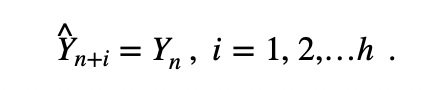

### Simple Exponential Smoothing (SES)
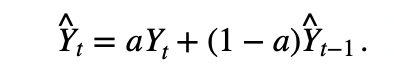

### Window Average
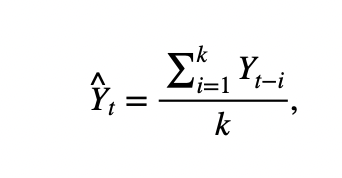

### Random walk with drift
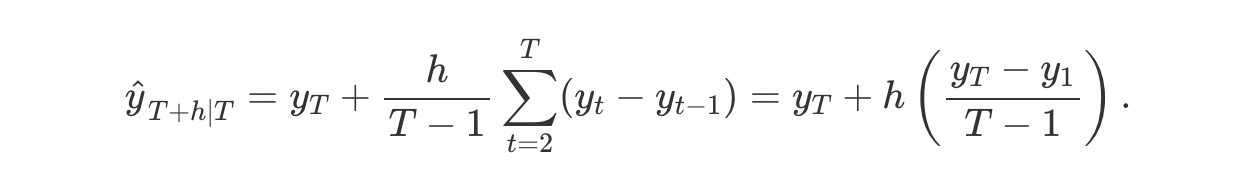

In [ ]:
train.groupby('unique_id').tail(1)

,unique_id,ds,y
256,102001,2021-05-31,286913.0
517,394913,2021-05-31,538439.0
778,753899,2021-05-31,783132.0
1039,394463,2021-05-31,269105.0
1300,394514,2021-05-31,296250.0
...,...,...,...
236200,394767,2021-05-31,81005.0
236461,753874,2021-05-31,216085.0
236722,394968,2021-05-31,142566.0
236983,395188,2021-05-31,68969.0


In [ ]:
fcst = StatsForecast(train.set_index('unique_id'), models=models, freq='M', n_jobs=cpu_count())

In [ ]:
%%time
forecasts_stats = fcst.forecast(4)

2022-01-25 21:00:29 statsforecast.core INFO: Computing forecasts
2022-01-25 21:00:31 statsforecast.core INFO: Computed forecasts for historic_average.
2022-01-25 21:00:31 statsforecast.core INFO: Computed forecasts for naive.
2022-01-25 21:00:32 statsforecast.core INFO: Computed forecasts for random_walk_with_drift.
2022-01-25 21:00:33 statsforecast.core INFO: Computed forecasts for ses_alpha-0.9.
2022-01-25 21:00:33 statsforecast.core INFO: Computed forecasts for window_average_window_size-4.


CPU times: user 170 ms, sys: 43.9 ms, total: 214 ms
Wall time: 4.59 s


In [ ]:
forecasts_stats.isna().mean()

ds                              0.0
historic_average                0.0
naive                           0.0
random_walk_with_drift          0.0
ses_alpha-0.9                   0.0
window_average_window_size-4    0.0
dtype: float64

In [ ]:
test = test.merge(forecasts_stats, how='left', on=['unique_id', 'ds'])

In [ ]:
evaluate_dataset(test, 4)

,mape,rmse,smape,mae
random_walk_with_drift,2.707986,8624.853176,2.774138,7848.350932
naive,3.161104,9842.392609,3.245135,8967.523102
ses_alpha-0.9,3.278455,10145.079829,3.367734,9296.870909
prophet,4.261593,13491.568388,4.424653,12429.364069
window_average_window_size-4,4.662784,13707.709446,4.827230,13079.987761
historic_average,27.053283,68887.369924,32.008035,68741.679378


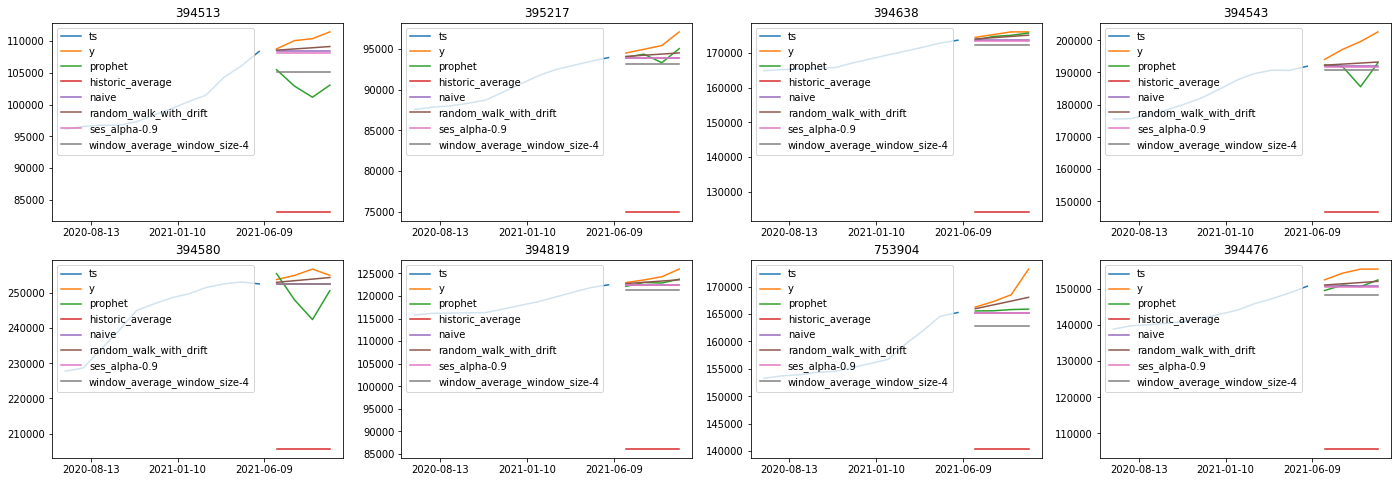

In [ ]:
plot_grid(train.groupby('unique_id').tail(12), test)

## MLForecast

In [ ]:
from mlforecast.core import TimeSeries
from mlforecast.forecast import Forecast
from sklearn.linear_model import LinearRegression
from window_ops.ewm import ewm_mean
from window_ops.expanding import expanding_mean

In [ ]:
ts = TimeSeries(
        freq='M',
        num_threads=cpu_count(),
        lags=list(range(1, 4)),
        lag_transforms={
            i: [(expanding_mean), 
                (ewm_mean, 0.1), 
                (ewm_mean, 0.3),
                (ewm_mean, 0.5),
                (ewm_mean, 0.7),
                (ewm_mean, 0.9)]
            for i in range(1, 4)
        },
        date_features=['year', 'quarter', 'month']
    )

In [ ]:
model = LinearRegression()
fcst = Forecast(model, ts)

In [ ]:
fcst.preprocess(train.set_index('unique_id'))

,ds,y,lag-1,lag-2,lag-3,expanding_mean_lag-1,ewm_mean_lag-1_alpha-0.1,ewm_mean_lag-1_alpha-0.3,ewm_mean_lag-1_alpha-0.5,ewm_mean_lag-1_alpha-0.7,ewm_mean_lag-1_alpha-0.9,expanding_mean_lag-2,ewm_mean_lag-2_alpha-0.1,ewm_mean_lag-2_alpha-0.3,ewm_mean_lag-2_alpha-0.5,ewm_mean_lag-2_alpha-0.7,ewm_mean_lag-2_alpha-0.9,expanding_mean_lag-3,ewm_mean_lag-3_alpha-0.1,ewm_mean_lag-3_alpha-0.3,ewm_mean_lag-3_alpha-0.5,ewm_mean_lag-3_alpha-0.7,ewm_mean_lag-3_alpha-0.9,year,quarter,month
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,
102001,2000-04-30,129016.0,128277.0,127914.0,127569.0,127920.000000,127670.850000,127853.850000,128009.250000,128137.050000,128237.250000,127741.500000,127603.500000,127672.500000,127741.500000,127810.500000,127879.500000,127569.000000,127569.000000,127569.000000,127569.000000,127569.000000,127569.000000,2000,2,4
102001,2000-05-31,129762.0,129016.0,128277.0,127914.0,128194.000000,127805.365000,128202.495000,128512.625000,128752.315000,128938.125000,127920.000000,127670.850000,127853.850000,128009.250000,128137.050000,128237.250000,127741.500000,127603.500000,127672.500000,127741.500000,127810.500000,127879.500000,2000,2,5
102001,2000-06-30,130505.0,129762.0,129016.0,128277.0,128507.600000,128001.028500,128670.346500,129137.312500,129459.094500,129679.612500,128194.000000,127805.365000,128202.495000,128512.625000,128752.315000,128938.125000,127920.000000,127670.850000,127853.850000,128009.250000,128137.050000,128237.250000,2000,2,6
102001,2000-07-31,131263.0,130505.0,129762.0,129016.0,128840.500000,128251.425650,129220.742550,129821.156250,130191.228350,130422.461250,128507.600000,128001.028500,128670.346500,129137.312500,129459.094500,129679.612500,128194.000000,127805.365000,128202.495000,128512.625000,128752.315000,128938.125000,2000,3,7
102001,2000-08-31,132072.0,131263.0,130505.0,129762.0,129186.571429,128552.583085,129833.419785,130542.078125,130941.468505,131178.946125,128840.500000,128251.425650,129220.742550,129821.156250,130191.228350,130422.461250,128507.600000,128001.028500,128670.346500,129137.312500,129459.094500,129679.612500,2000,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753929,2021-01-31,99183.0,98629.0,97699.0,96674.0,76152.422222,95510.134326,97369.175128,97916.060751,98260.847402,98525.813493,75984.686567,95163.593696,96829.250183,97203.121501,97401.824673,97597.134932,75821.421053,94881.881884,96456.500261,96707.243002,96708.415576,96680.349318,2021,1,1
753929,2021-02-28,99619.0,99183.0,98629.0,97699.0,76321.764706,95877.420893,97913.322589,98549.530375,98906.354221,99117.281349,76152.422222,95510.134326,97369.175128,97916.060751,98260.847402,98525.813493,75984.686567,95163.593696,96829.250183,97203.121501,97401.824673,97597.134932,2021,1,2
753929,2021-03-31,100022.0,99619.0,99183.0,98629.0,76491.817518,96251.578804,98425.025813,99084.265188,99405.206266,99568.828135,76321.764706,95877.420893,97913.322589,98549.530375,98906.354221,99117.281349,76152.422222,95510.134326,97369.175128,97916.060751,98260.847402,98525.813493,2021,1,3


In [ ]:
%%time
fcst.fit(train.set_index('unique_id'))
forecasts_ml = fcst.predict(4).rename(columns={'y_pred': 'mlforecast_lr'})

CPU times: user 668 ms, sys: 175 ms, total: 843 ms
Wall time: 587 ms


In [ ]:
forecasts_ml.head()

,ds,mlforecast_lr
unique_id,,
102001,2021-06-30,291308.712221
102001,2021-07-31,295514.404441
102001,2021-08-31,299281.988998
102001,2021-09-30,303083.374362
394297,2021-06-30,181366.703621


In [ ]:
test = test.merge(forecasts_ml, how='left', on=['unique_id', 'ds'])

In [ ]:
evaluate_dataset(test, 4)

,mape,rmse,smape,mae
mlforecast_lr,0.942855,3037.306378,0.951257,2595.471427
random_walk_with_drift,2.707986,8624.853176,2.774138,7848.350932
naive,3.161104,9842.392609,3.245135,8967.523102
ses_alpha-0.9,3.278455,10145.079829,3.367734,9296.870909
prophet,4.261593,13491.568388,4.424653,12429.364069
window_average_window_size-4,4.662784,13707.709446,4.827230,13079.987761
historic_average,27.053283,68887.369924,32.008035,68741.679378


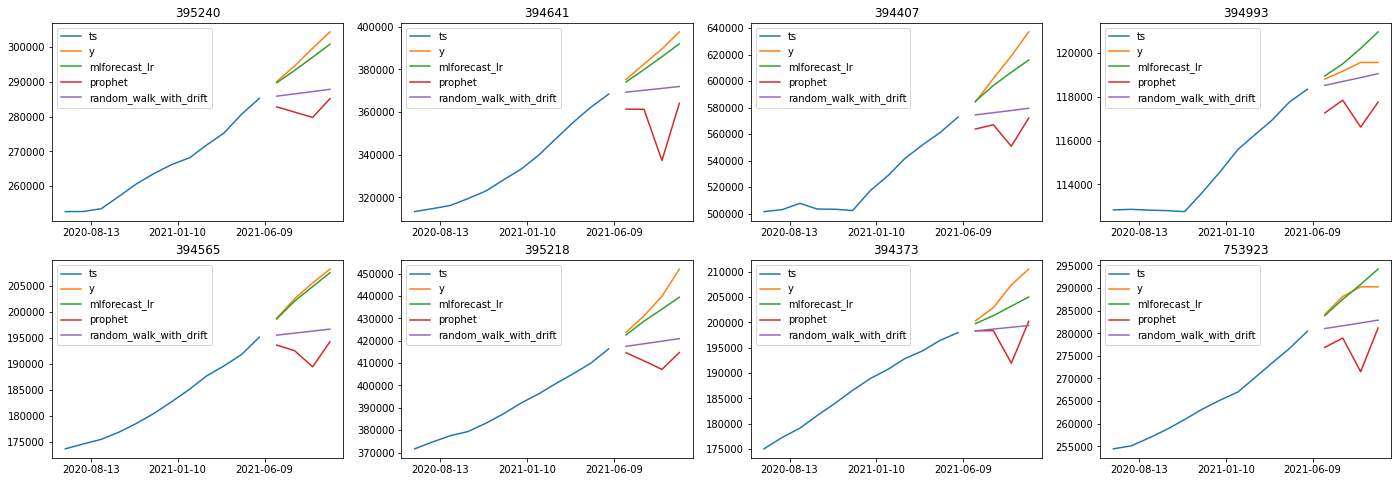

In [ ]:
plot_grid(train.groupby('unique_id').tail(12), test[['unique_id', 'ds', 'y', 'mlforecast_lr', 'prophet', 'random_walk_with_drift']])

### Using LGBM

In [ ]:
import lightgbm as lgb

In [ ]:
%%time
model = lgb.LGBMRegressor()
fcst = Forecast(model, ts)
fcst.fit(train.set_index('unique_id'))
forecasts_lgbm = fcst.predict(4).rename(columns={'y_pred': 'mlforecast_lgbm'})

CPU times: user 5.34 s, sys: 81.5 ms, total: 5.42 s
Wall time: 3.37 s


In [ ]:
forecasts_lgbm.head()

,ds,mlforecast_lgbm
unique_id,,
102001,2021-06-30,289248.248928
102001,2021-07-31,295116.824222
102001,2021-08-31,300887.818323
102001,2021-09-30,307590.986048
394297,2021-06-30,182512.836333


In [ ]:
test = test.merge(forecasts_lgbm, how='left', on=['unique_id', 'ds'])

In [ ]:
evaluate_dataset(test, 4)

,mape,rmse,smape,mae
mlforecast_lr,0.942855,3037.306378,0.951257,2595.471427
mlforecast_lgbm,1.703992,6339.108631,1.726951,5684.538401
random_walk_with_drift,2.707986,8624.853176,2.774138,7848.350932
naive,3.161104,9842.392609,3.245135,8967.523102
ses_alpha-0.9,3.278455,10145.079829,3.367734,9296.870909
prophet,4.261593,13491.568388,4.424653,12429.364069
window_average_window_size-4,4.662784,13707.709446,4.827230,13079.987761
historic_average,27.053283,68887.369924,32.008035,68741.679378


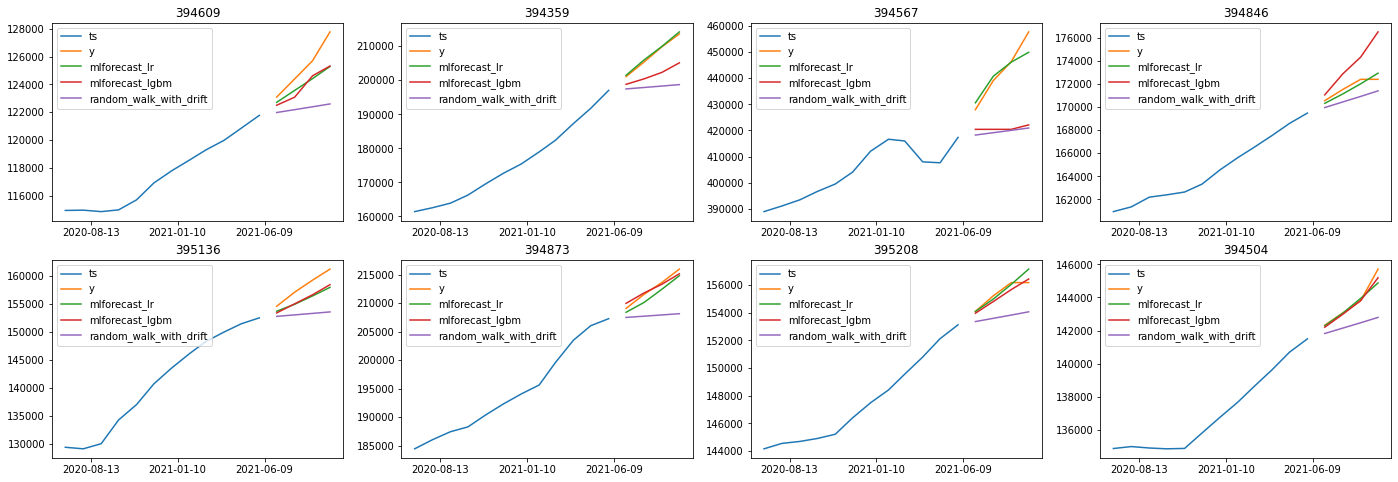

In [ ]:
plot_grid(train.groupby('unique_id').tail(12), test[['unique_id', 'ds', 'y', 'mlforecast_lr', 'mlforecast_lgbm', 'random_walk_with_drift']])